In [322]:
using Plots
using ForwardDiff
using Base.Threads
using LinearAlgebra
using LogExpFunctions, Distances
using WassersteinDictionaries
using Gridap
using Gridap.GridapODEs
using Gridap.FESpaces
using Gridap.CellData
using LineSearches
using Test
using Statistics
using SparseArrays: spzeros
using Random

In [323]:
Threads.nthreads()

8

In [324]:
σ = sqrt(1e-3)    # inital condition 

tol = 1e-3

function f(x, x0)
  exp(-((x[1] - x0[1])^2 + (x[2] - x0[2])^2) / 2 / σ^2) / (2π*σ^2)
end

μ_min = -0.35
μ_max = 0.35

u(x) = 0.0

N = 64

domain = (0,1,0,1)
partition = (N,N)
model = CartesianDiscreteModel(domain,partition)

highorder = 3

V₂ = FESpace(
  model,
  ReferenceFE(lagrangian,Float64,highorder),
  conformity=:H1,
  dirichlet_tags="boundary"
)
U₂ = TrialFESpace(V₂,u)

Ω = Triangulation(model)
degree = 2*highorder
dΩ = Measure(Ω,degree)
;

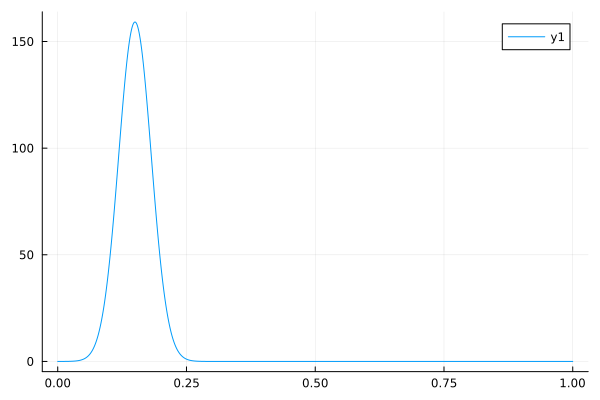

In [325]:
plot(0:0.001:1, x -> exp(-((x - 0.15)^2) / 2 / σ^2) / (2π*σ^2))

In [326]:
nₛ = 100

uₕ = []
μ̄ = []
κₕ = []

Random.seed!(1234)
for i in 1:nₛ

    if i == 1
        μ = zeros(2)
    else
        μ = rand(2) .* (μ_max - μ_min) .+ μ_min
    end
    x0 = μ .+ 0.5
    f(x) = f(x, x0)

    push!(κₕ, interpolate_everywhere(f, V₂))

    a(u,v) = ∫( (∇(v)⋅∇(u)) )dΩ
    b(v) = ∫( f*v )dΩ

    op = AffineFEOperator(a,b,U₂,V₂)
    push!(uₕ, solve(op))
    push!(μ̄, μ)
end

In [327]:
C = [ sum(∫((uₕ[i]) ⋅ (uₕ[j]) )dΩ) for i in eachindex(uₕ), j in eachindex(uₕ) ]
evd = eigen(C, sortby = x -> -abs(x) );

In [328]:
C_H1 = [ sum(∫(∇(uₕ[i]) ⋅ ∇(uₕ[j]) )dΩ) for i in eachindex(uₕ), j in eachindex(uₕ) ] + C
evd_H1 = eigen(C_H1, sortby = x -> -abs(x) );

In [329]:
using LaTeXStrings

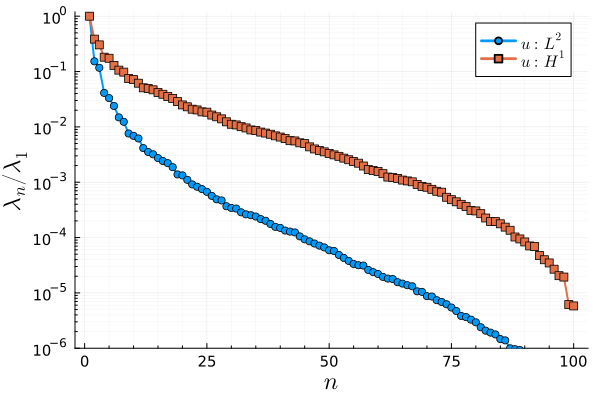

In [330]:
plot(abs.(evd.values[1:nₛ]) ./ evd.values[1], yaxis = :log, minorgrid = true, 
linewidth=2, marker = :circle, xlabel = L"n", ylabel = L"\lambda_n / \lambda_1", ylim = (1e-6,1.2), label = L"u : L^2",
legendfontsize=11, tickfontsize=10, xguidefontsize=16, yguidefontsize=16) 
plot!(abs.(evd_H1.values[1:nₛ]) ./ evd_H1.values[1], linewidth=2, marker = :square, label = L"u : H^1",
legendfontsize=11, tickfontsize=10, xguidefontsize=16, yguidefontsize=16) 

In [331]:
# obtain n
function _get_n(v, tol = 1e-3)
    for i in 1:length(v)
        if sum(v[1:i])/sum(v) > 1 - tol
            return i
        end
    end
end
n = _get_n(evd.values, tol)

41

In [332]:
ϕ = []
for i in 1:n
    fv = zero_free_values(U₂) # dof vector
    for j in eachindex(uₕ)
        fv_j = get_free_dof_values(uₕ[j])
        fv .+= fv_j * evd.vectors[j,i]
    end
    fv ./= sqrt(evd.values[i])
    _ϕ = FEFunction(V₂,fv)
    push!(ϕ, _ϕ)
end

In [333]:
#@test [ sum(∫(ϕ[i]*ϕ[j])dΩ) + sum(∫(∇(ϕ[i]) ⋅ ∇(ϕ[j]))dΩ) for i in eachindex(ϕ), j in eachindex(ϕ) ] ≈ I atol = 1e-6
@test [ sum(∫(ϕ[i]*ϕ[j])dΩ) for i in eachindex(ϕ), j in eachindex(ϕ) ] ≈ I atol = 1e-6

Test Passed

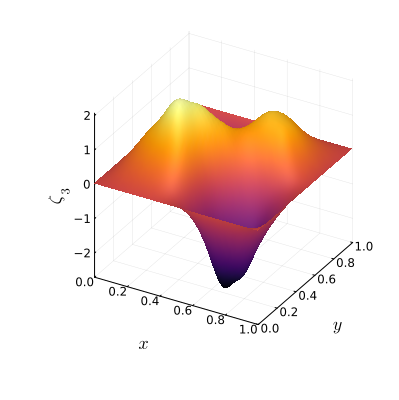

In [334]:
x_cord = 0:0.02:1
surface(x_cord,x_cord, (x,y) -> -ϕ[4](Point(x,y)),
cbar = false, xlabel = L"x", ylabel = L"y", zlabel = L"\zeta_3", size = (400,400), camera = (30,30),
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12, zguidefontsize=12)

In [335]:
uₕₜ = []
μ̄ₜ = []

nₜ = 50

t_hf_sol = 0

Random.seed!(4932)

for i in 1:nₜ
    μ = rand(2) .* (μ_max - μ_min) .+ μ_min
    x0 = μ .+ 0.5
    f(x) = f(x, x0)

    _, _t_hf_sol = @timed begin
        a(u,v) = ∫( (∇(v)⋅∇(u)) )dΩ
        b(v) = ∫( f*v )dΩ

        op = AffineFEOperator(a,b,U₂,V₂)
        _uₕₜ = solve(op)
        
    end
    t_hf_sol += _t_hf_sol
    
    push!(uₕₜ, _uₕₜ)
    push!(μ̄ₜ, μ)
end

In [336]:
t_hf_sol

23.643658204999994

In [337]:
uₕₜ_rb = []
t_rb_assem = 0
t_rb_sol = 0

_, _t_rb_assem = @timed begin
    Aᵣ = [ sum(∫( (∇(ϕ[i])⋅∇(ϕ[j])) )dΩ) for i in eachindex(ϕ), j in eachindex(ϕ) ]
end
#t_rb_assem += _t_rb_assem

for i in 1:nₜ
    μ = μ̄ₜ[i]
    x0 = μ .+ 0.5
    f(x) = f(x, x0)

    _, _t_rb_assem = @timed begin
        bᵣ = [ sum(∫( ϕ[i]*f )dΩ) for i in eachindex(ϕ) ]
    end
    t_rb_assem += _t_rb_assem

    _, _t_rb_sol = @timed begin
        _u = Aᵣ \ bᵣ
        _uₕ = FEFunction(V₂, _u' * get_free_dof_values.(ϕ[1:n]) )
    end
    t_rb_sol += _t_rb_sol

    push!(uₕₜ_rb, _uₕ)
end

In [338]:
t_rb_assem, t_rb_sol

(43.66205091599999, 0.06989266300000001)

In [339]:
L2(e) = sqrt(sum( ∫( e*e )*dΩ ))
H1(e) = sqrt(sum( ∫( e*e + ∇(e)⋅∇(e) )*dΩ ))

H1 (generic function with 1 method)

In [340]:
ΔL2_rb_online = [ L2(uₕₜ_rb[i]-uₕₜ[i]) / L2(uₕₜ[i]) for i in eachindex(uₕₜ) ]
ΔH1_rb_online = [ H1(uₕₜ_rb[i]-uₕₜ[i]) / H1(uₕₜ[i]) for i in eachindex(uₕₜ) ]
Statistics.mean(ΔL2_rb_online), Statistics.std(ΔL2_rb_online; corrected=false), maximum(ΔL2_rb_online)

(0.07815034172686547, 0.06222491827226094, 0.28640171219578514)

In [341]:
Statistics.mean(ΔH1_rb_online), Statistics.std(ΔH1_rb_online; corrected=false), maximum(ΔH1_rb_online)

(0.304587614057424, 0.1345653229268867, 0.657000266088692)

In [342]:
n, length(get_free_dof_values(uₕ[1])), N

(41, 36481, 64)

In [343]:
Mᵣ = [ sum(∫( ((ϕ[i])⋅(ϕ[j])))dΩ) for i in eachindex(ϕ), j in eachindex(ϕ) ];

In [344]:
# RB projection
#ũ = [ Mᵣ \ [ sum(∫(_uₕ * _ϕ)dΩ) for _ϕ in ϕ] for _uₕ in uₕₜ ]
ũ = [ [ sum(∫(_uₕ * _ϕ)dΩ) for _ϕ in ϕ] for _uₕ in uₕₜ ]
uᵣ = [ FEFunction(V₂, _ũ' * get_free_dof_values.(ϕ)) for _ũ in ũ ]
;

# RB error
ΔL2_rb_proj = [ L2(uᵣ[i]-uₕₜ[i]) / L2(uₕₜ[i]) for i in eachindex(uₕₜ) ]
ΔH1_rb_proj = [ H1(uᵣ[i]-uₕₜ[i]) / H1(uₕₜ[i]) for i in eachindex(uₕₜ) ]
Statistics.mean(ΔL2_rb_proj), maximum(ΔL2_rb_proj)

(0.07088962597340405, 0.24148978084955378)

# Transport

In [345]:
N_fine = highorder*N
partition_fine = (N_fine,N_fine)
model_fine = CartesianDiscreteModel(domain,partition_fine)

V₁ = FESpace(
  model_fine,
  ReferenceFE(lagrangian,Float64,1),
  conformity=:H1
);

In [346]:
N_fine

192

In [347]:
Ψ = FESpace(
  model,
  ReferenceFE(lagrangian,Float64,3),
  conformity=:H1,
  #constraint=:zeromean
);

In [348]:
# Wasserstein calcs
d = 2
c = WassersteinDictionaries.get_cost_matrix_separated(N_fine+1, d, a = [domain[1] domain[3]], b = [domain[2] domain[4]])

ε = 1e-3

k = WassersteinDictionaries.get_gibbs_matrix(c, ε)
minimum(k[1])

7.124576406741286e-218

In [426]:
#ūₕ = [ reshape( abs.(get_free_dof_values( interpolate_everywhere(Interpolable((_uₕ)), V₁) )),N_fine+1,N_fine+1) for _uₕ in uₕ];
ūₕ = [ reshape( abs.(get_free_dof_values( interpolate_everywhere(Interpolable((_uₕ)⋅(_uₕ)), V₁) )),N_fine+1,N_fine+1) for _uₕ in uₕ];
#ūₕ = [ reshape( abs.(get_free_dof_values( interpolate_everywhere(Interpolable(_κₕ), V₁) )),N_fine+1,N_fine+1) for _κₕ in κₕ];
;

In [ ]:
for _ūₕ in ūₕ
    _ūₕ ./= sum(_ūₕ) * (1 / N_fine)^2
end

In [ ]:
# calculate reference measure
SPB = SinkhornParameters(256, ε)
SPB.debias = true
SPB.averaged_updates = false
SPB.update_potentials = false

MC = MatrixCache(N_fine+1)
SPB.tol = 1e-12

Random.seed!(2424)

nᵦ = 25
ūₕᵦ = ūₕ[rand(1:nₛ,nᵦ)]

a_₀ = [ones(size(_ūₕ)) for _ūₕ in ūₕᵦ] 
d₀ = ones(size(ūₕ[1]));

In [ ]:
@time ūₕ_ref = sinkhorn_barycenter_sep([ 1/nᵦ for _ in ūₕᵦ], ūₕᵦ, a_₀, d₀, k, SPB, MC);
#ūₕ_ref = ūₕ[1];
;

In [ ]:
function safe_log(x)
    if x > 1e-20
        return log(x)
    else
        return -100.0
    end
end

In [ ]:
log_ūₕ = [ safe_log.(_ūₕ) for _ūₕ in ūₕ ];
log_ūₕ_ref = safe_log.(ūₕ_ref);

In [ ]:
# compute transport potentials from ū to ū_ref
ψ̄  = [ zero(_ūₕ) for _ūₕ in ūₕ ]
ψ̄ᶜ = [ zero(_ūₕ) for _ūₕ in ūₕ ] 

a₀ = zero(ūₕ[1])
b₀ = zero(ūₕ[1])
d₀₁ = zero(ūₕ[1])
d₀₂ = zero(ūₕ[1])

SP = SinkhornParameters(128, ε)
SP.tol = 1e-12

SP.debias = false
SP.averaged_updates = false
SP.update_potentials = true

for s in eachindex(ūₕ)

    a₀ .= 1.0
    b₀ .= 1.0

    #ψ[s] .= log.(a_₀[s]) * ε # if barycenter was computed from all snaps

    sinkhorn_dvg_sep( ūₕ[s], ūₕ_ref, a₀, b₀, d₀₁, d₀₂, k, SP, MC)
    ψ̄[s] .= log.(a₀) * ε
    ψ̄ᶜ[s] .= log.(b₀) * ε

    #WassersteinDictionaries.softmin_separated!(ψ̄ᶜ[s], ψ̄[s], log_ūₕ[s], 1e-3, c, MC[:t1,Float64], MC[:t2,Float64])
end

In [ ]:
uₕ_ref = interpolate_everywhere( Interpolable( FEFunction(V₁, vec(ūₕ_ref))), Ψ);
#uₕ_ref_1 = FEFunction(V₁, vec(ūₕ_ref));
;

In [ ]:
plot(0:0.001:1, x -> uₕ_ref(Point(x,x)), legend = false)

In [ ]:
# H¹₀ projections

Γ = BoundaryTriangulation(model)
nb = get_normal_vector(Γ)
dΓ = Measure(Γ,degree)

In [ ]:
# H¹₀ projections
ϵ = 1
δ = 0
δ_barrier = 1e9 * N_fine

ψ = []
ψᶜ = []

nb = get_normal_vector(Γ)
Γ = BoundaryTriangulation(model)
dΓ = Measure(Γ,degree)

#=
for i in eachindex(ψ̄)
    ψ₁ = interpolate_everywhere( Interpolable( FEFunction(V₁, vec(ψ̄[i]))), Ψ)

    a(u,v) = ∫( (∇(v)⋅∇(u)) )dΩ + ϵ * ∫( v*u )dΩ + δ * ∫( nb⋅(nb⋅∇∇(u))*v )dΓ + δ_barrier * ∫( (nb⋅∇(u))*v )dΓ
    b(v) = ∫( (∇(v)⋅∇(ψ₁)) )dΩ + ϵ * ∫( v*ψ₁ )dΩ #- ∫( (nb⋅∇(ψ₁))*v )dΓ 

    op = AffineFEOperator(a,b,TrialFESpace(Ψ),Ψ)

    push!(ψ, solve(op))
    
    #push!(ψ, ψ₁)
end
=#

for i in eachindex(ψ̄ᶜ)
    ψ₁ = interpolate_everywhere( Interpolable( FEFunction(V₁, vec(ψ̄ᶜ[i]))), Ψ)

    a(u,v) = ∫( (∇(v)⋅∇(u)) )dΩ + ϵ * ∫( v*u )dΩ + δ * ∫( nb⋅(nb⋅∇∇(u))*v )dΓ + δ_barrier * ∫( (nb⋅∇(u))*v )dΓ
    b(v) = ∫( (∇(v)⋅∇(ψ₁)) )dΩ + ϵ * ∫( v*ψ₁ )dΩ #- ∫( (nb⋅∇(ψ₁))*v )dΓ 

    op = AffineFEOperator(a,b,TrialFESpace(Ψ),Ψ)

    push!(ψᶜ, solve(op))

    #push!(ψᶜ, ψ₁)
end

In [ ]:
# Assemble C matrix
Cψ = [ sum(∫(∇(ψᶜᵢ)⋅∇(ψᶜⱼ)*uₕ_ref)dΩ) for ψᶜᵢ in ψᶜ, ψᶜⱼ in ψᶜ ]
evdψ = eigen(Cψ, sortby = x -> -abs(x))
;

In [ ]:
# Assemble C matrix
#Cψ2 = [ sum(∫(∇(ψᶜᵢ)⋅∇(ψᶜⱼ))dΩ) for ψᶜᵢ in ψ, ψᶜⱼ in ψ ]
#evdψ2 = eigen(Cψ2, sortby = x -> -abs(x))
;

In [ ]:
plot(abs.(evd.values[1:nₛ]) ./ evd.values[1], yaxis = :log, minorgrid = true, 
linewidth=2, marker = :circle, xlabel = L"n", ylabel = L"\lambda_n / \lambda_1", ylim = (1e-6,1.2), label = L"u",
legendfontsize=12, tickfontsize=10, xguidefontsize=14, yguidefontsize=14) 
plot!(abs.(evdψ.values[1:nₛ]) ./ evdψ.values[1], linewidth=2, marker = :square, label = L"\nabla \psi^c",
legendfontsize=12, tickfontsize=10, xguidefontsize=14, yguidefontsize=14) 

In [1]:
tol = 1e-5

1.0e-5

In [2]:
# obtain m
m = _get_n(evdψ.values, tol)

UndefVarError: UndefVarError: evdψ not defined

In [365]:
# obtain the transport modes
ξᶜ = []
for i in 1:m
    fv = zero_free_values(Ψ) # dof vector
    for j in eachindex(uₕ)
        fv_j = get_free_dof_values(ψᶜ[j])
        fv .+= fv_j * evdψ.vectors[j,i]
    end
    fv ./= sqrt(evdψ.values[i])
    _ξᶜ = FEFunction(Ψ,fv)
    push!(ξᶜ, _ξᶜ)
end

In [366]:
@test [ sum(∫(∇(ξᶜ[i])⋅∇(ξᶜ[j])*uₕ_ref)dΩ)  for i in eachindex(ξᶜ), j in eachindex(ξᶜ) ] ≈ I atol = 1e-6

Test Passed

In [367]:
# plot some transport modes
x_cord = 0:0.1:1
plts = []
for i in 1:(minimum((m,4)))
    push!(plts, contourf(x_cord,x_cord, (x,y) -> ξᶜ[i](Point(x,y)) - ξᶜ[i](Point(0.5,0.5)) ))
end

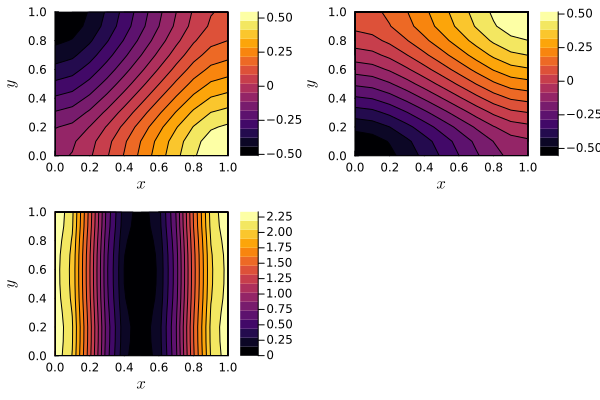

In [368]:
plot(plts..., xlabel = L"x", ylabel = L"y", cgrad = :thermal, legend=false, grid=false)

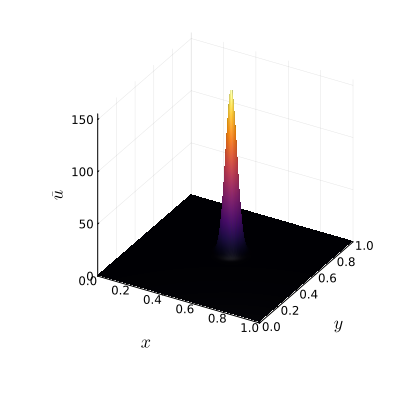

In [369]:
x_cord = 0:0.01:1
surface(x_cord,x_cord, (x,y) -> uₕ_ref(Point(x,y)),
cbar = false, xlabel = L"x", ylabel = L"y", zlabel = L"\bar u", size = (400,400), camera = (30,30),
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12, zguidefontsize=12)
#savefig("../figs/ubar.pdf")

In [370]:
x_cord = 0:0.01:1
surface(x_cord,x_cord, (x,y) -> ξᶜ[4](Point(x,y)) - ξᶜ[4](Point(0.5,0.5)),
cbar = false, xlabel = L"x", ylabel = L"y", zlabel = L"\xi^c_4", size = (400,400), camera = (30,30),
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12, zguidefontsize=12)
#savefig("../figs/xi4.pdf")

BoundsError: BoundsError: attempt to access 3-element Vector{Any} at index [4]

In [371]:
[ sum(∫( abs(nb⋅∇(ξᶜ[i])) )dΓ) for i in 1:m ]

3-element Vector{Float64}:
 5.1070735778431326e-11
 4.789415197871387e-11
 1.4597749517336262e-9

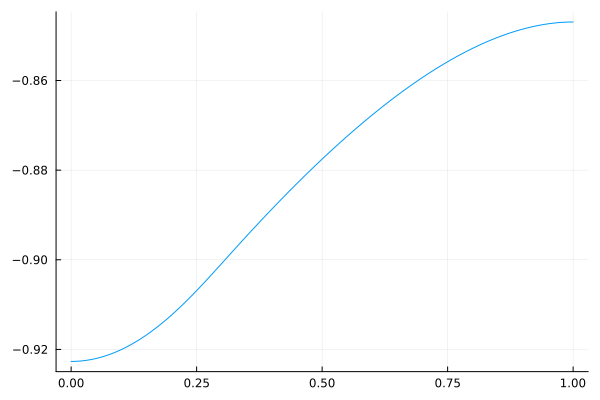

In [372]:
_ψᶜ = ψᶜ[rand(1:nₛ)]
plot(0:0.001:1, x -> _ψᶜ(Point(0.5,x)), legend = false)

In [373]:
# get the reduced representation of the ψ
λ = [ [ sum(∫(∇(_ψᶜ)⋅∇(_ξᶜ)*uₕ_ref)dΩ) for _ξᶜ in ξᶜ ] for _ψᶜ in ψᶜ ]
ψᶜᵣ = [ FEFunction(Ψ, _λ' * get_free_dof_values.(ξᶜ)) for _λ in λ ]
;

In [374]:
L2_ψ = [ sum(∫(∇(ψᶜ[i] - ψᶜᵣ[i])⋅∇(ψᶜ[i] - ψᶜᵣ[i])*uₕ_ref)dΩ) / sum(∫(∇(ψᶜ[i])⋅∇(ψᶜ[i])*uₕ_ref)dΩ) for i in eachindex(ψᶜ) ];

In [375]:
Statistics.mean(L2_ψ), Statistics.std(L2_ψ; corrected=false), maximum(L2_ψ)

(0.0009749779162646126, 0.0018630882721681608, 0.011562670052552767)

In [376]:
function c̄_transform(_λ, ξᶜ, ε = 1e-9)

    _ψᶜᵣ = FEFunction(Ψ, _λ' * get_free_dof_values.(ξᶜ))

    _ψᶜᵣ₀ = interpolate_everywhere(Interpolable(_ψᶜᵣ), V₁)

    _ψ̄ᶜᵣ = reshape( get_free_dof_values(_ψᶜᵣ₀), N_fine+1, N_fine+1)

    #_ψ̄ᶜᵣ = reshape(_λ' * get_free_dof_values.(ξᶜ), N2+1, N2+1)

    # approximate mapping to reference configuration
    _ψ̄ᵣ = zero(_ψ̄ᶜᵣ)
    WassersteinDictionaries.softmin_separated!(_ψ̄ᵣ, _ψ̄ᶜᵣ, log_ūₕ_ref, 1e-6, c, MC[:t1,Float64], MC[:t2,Float64])
    #WassersteinDictionaries.softmin_separated!(_ψ̄ᵣ, _ψ̄ᶜᵣ, log_unif, 1e-12, c, MC[:t1,Float64], MC[:t2,Float64])
    
    _ψᵣ₀ = FEFunction(V₁, vec(_ψ̄ᵣ))

    _ψᵣ = interpolate_everywhere( Interpolable(_ψᵣ₀), Ψ)

    #_ψᵣ = FEFunction(Ψ, vec(_ψ̄ᵣ)) 

    _ψᵣ
end

c̄_transform (generic function with 2 methods)

In [377]:
#ψᵣ = [ c̄_transform(_λ, ξᶜ) for _λ in λ ];

In [378]:
#Statistics.mean([ sum(∫(∇(ψ[i] - ψᵣ[i])⋅∇(ψ[i] - ψᵣ[i])*uₕ[i])dΩ) / sum(∫(∇(ψ[i])⋅∇(ψ[i])*uₕ[i])dΩ) for i in eachindex(ψᶜ) ]),
#Statistics.mean([ sum(∫(∇(ψ[i] - ψᵣ[i])⋅∇(ψ[i] - ψᵣ[i])*κₕ[i])dΩ) / sum(∫(∇(ψ[i])⋅∇(ψ[i])*κₕ[i])dΩ) for i in eachindex(ψᶜ) ]),
#Statistics.mean([ sum(∫(∇(ψ[i] - ψᵣ[i])⋅∇(ψ[i] - ψᵣ[i]))dΩ) / sum(∫(∇(ψ[i])⋅∇(ψ[i]))dΩ) for i in eachindex(ψᶜ) ])

In [379]:
id = TensorValue(diagm(ones(2)))

TensorValue{2, 2, Float64, 4}(1.0, 0.0, 0.0, 1.0)

In [380]:
function pushfwd(u,ψ,V)

    T = Float64

    u_cache = Gridap.CellData.return_cache(u, Point(0,0))
    psi_cache = Gridap.CellData.return_cache(∇(ψ), Point(0,0))

    function uT(y)
        dy = Gridap.evaluate!(psi_cache, ∇(ψ), y)
        Ty = y - dy
        if Ty[1] < domain[1] || Ty[1] > domain[2] || Ty[2] < domain[3] || Ty[2] > domain[4]
            return zero(T)
        else
            return Gridap.evaluate!(u_cache, u, Ty)
        end
    end

    U = u.fe_space
    Ω = get_triangulation(u)

    dΩc = Measure(Ω,2*highorder)
    a(u,v) = ∫( u*v )*dΩc
    l(v) = ∫( v*uT )*dΩc
    op = AffineFEOperator(a,l,U,V)

    return solve(op)
end


pushfwd (generic function with 1 method)

In [381]:
@time _Tuₕ = pushfwd(uₕ[1],ψᶜᵣ[1],V₂)

  2.775540 seconds (5.50 M allocations: 528.251 MiB, 2.75% gc time, 79.65% compilation time)


SingleFieldFEFunction():
 num_cells: 4096
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 9750814855069193529

In [382]:
Tuₕ = copy(uₕ);
@time for i in eachindex(uₕ) 
    Tuₕ[i] = pushfwd(uₕ[i],ψᶜᵣ[i],V₂)
end

 51.458635 seconds (322.41 M allocations: 39.286 GiB, 6.38% gc time)


In [383]:
cpal = palette(:thermal, 7);

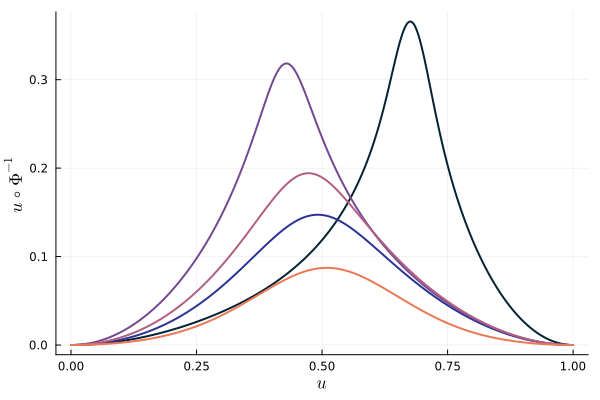

In [384]:
x_cord = 0:0.001:1
plt = plot()
_i = 1
idxs = rand(1:nₛ,5)
for i in idxs
    plot!(x_cord, x -> Tuₕ[i](Point(x,x)), legend = false,
    linewidth = 2, color = cpal[_i], xlabel = L"u", ylabel = L"u \circ \Phi^{-1}",
    legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
    _i += 1
end
plt

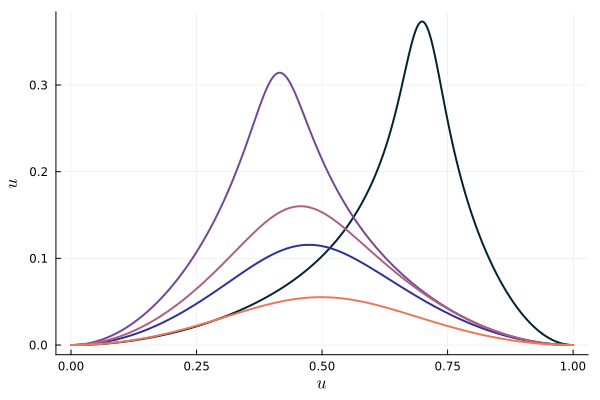

In [385]:
plt = plot()
_i = 1
for i in idxs
    plot!(x_cord, x -> uₕ[i](Point(x,x)), legend = false,
    linewidth = 2, color = cpal[_i], xlabel = L"u", ylabel = L"u",
    legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
    _i += 1
end
plt

In [386]:
# Assemble C matrix
CT = [ sum(∫( (uₕᵢ) ⋅ (uₕⱼ))dΩ) for uₕᵢ in Tuₕ, uₕⱼ in Tuₕ ]
evdT = eigen(CT, sortby = x -> -abs(x))
;

InterruptException: InterruptException:

In [387]:
CT_H1 = [ sum(∫( ∇(uₕᵢ) ⋅ ∇(uₕⱼ))dΩ) for uₕᵢ in Tuₕ, uₕⱼ in Tuₕ ] + CT
evdT_H1 = eigen(CT_H1, sortby = x -> -abs(x));

InterruptException: InterruptException:

In [388]:
N_fine

192

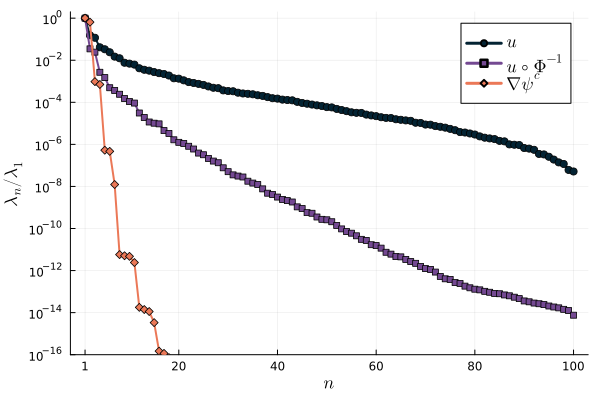

In [389]:
cpal = palette(:thermal, 4);

plot(abs.(evd.values[1:nₛ]) ./ evd.values[1], yaxis = :log, minorgrid = false, yticks = 10.0 .^ (-16:2:0), xticks = vcat(1,20:20:100),
linewidth=2, marker = :circle, xlabel = L"n", ylabel = L"\lambda_n / \lambda_1", ylim = (1e-16,2), label = L"u", color = cpal[1],
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
plot!(abs.(evdT.values[1:nₛ]) ./ evdT.values[1], linewidth=2, marker = :square, markersize = 3, label = L"u \circ \Phi^{-1}", color = cpal[2])
plot!(abs.(evdψ.values[1:nₛ]) ./ evdψ.values[1], linewidth=2, marker = :diamond, label = L"\nabla \psi^c", color = cpal[3])
#savefig("../figs/evds.pdf")

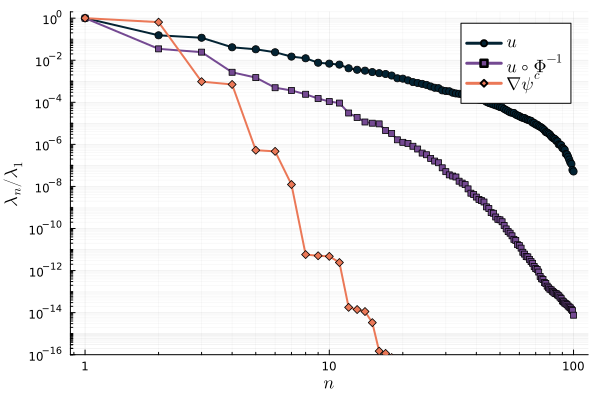

In [390]:
cpal = palette(:thermal, 4);

plot(abs.(evd.values[1:100]) ./ evd.values[1], yaxis = :log, minorgrid = true, xaxis = :log,
yticks = 10.0 .^ (-16:2:0), xticks = ( [1,10,100], string.([1,10,100]) ),
linewidth=2, marker = :circle, xlabel = L"n", ylabel = L"\lambda_n / \lambda_1", ylim = (1e-16,2), label = L"u", color = cpal[1],
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
plot!(abs.(evdT.values[1:100]) ./ evdT.values[1], linewidth=2, marker = :square, markersize = 3, label = L"u \circ \Phi^{-1}", color = cpal[2])
plot!(abs.(evdψ.values[1:100]) ./ evdψ.values[1], linewidth=2, marker = :diamond, label = L"\nabla \psi^c", color = cpal[3])
#savefig("../figs/evds_log.pdf")

In [391]:
nₘ = _get_n(evdT.values, tol)
n, m, nₘ

(41, 3, 6)

In [392]:
# obtain the reference basis
ϕσ = []
for i in 1:nₘ
    fv = zero_free_values(V₂) # dof vector
    for j in eachindex(Tuₕ)
        fv_j = get_free_dof_values(Tuₕ[j])
        fv .+= fv_j * evdT.vectors[j,i]
    end
    fv ./= sqrt(evdT.values[i])
    _ϕσ = FEFunction(V₂,fv)
    push!(ϕσ, _ϕσ)
end

In [393]:
# plot some reference RB functions
x_cord = 0:0.02:1
plts = []
for i in 1:(minimum((nₘ,4)))
    push!(plts, contourf(x_cord,x_cord, (x,y) -> ϕσ[i](Point(x,y)) ))
end

InterruptException: InterruptException:

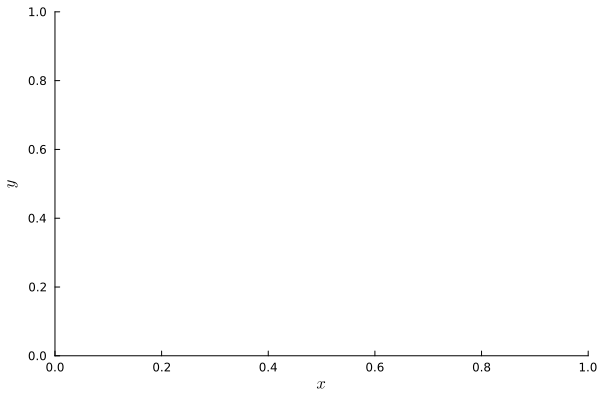

In [394]:
plot(plts..., xlabel = L"x", ylabel = L"y", legend=false, grid=false)

In [395]:
x_cord = 0:0.01:1
surface(x_cord,x_cord, (x,y) -> -ϕσ[1](Point(x,y)),
cbar = false, xlabel = L"x", ylabel = L"y", zlabel = L"\phi_1", size = (400,400), camera = (30,30),
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12, zguidefontsize=12)
#savefig("../figs/phi1.pdf")

InterruptException: InterruptException:

In [396]:
x_cord = 0:0.01:1
surface(x_cord,x_cord, (x,y) -> -ϕ[3](Point(x,y)),
cbar = false, xlabel = L"x", ylabel = L"y", zlabel = L"\zeta_3", size = (400,400), camera = (30,30),
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12, zguidefontsize=12)
#savefig("../figs/zeta3.pdf")

InterruptException: InterruptException:

In [397]:
m

3

In [398]:
plt = plot()
_i = 1
cpal = palette(:thermal, 1 + minimum((7,nₘ)))
for i in 1:minimum((7,nₘ))
    plot!(0:0.001:1,  x -> -ϕσ[i](Point([x,x])), legend = false,
    linewidth = 2, color = cpal[i], xlabel = L"x", ylabel = L"\phi", ylim = (-5,5),
    legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
    _i += 1
end
plt
#savefig("../figs/phis.pdf")

InterruptException: InterruptException:

In [399]:
plt = plot()
_i = 1
cpal = palette(:thermal, 1 + minimum((7,nₘ)))
for i in 1:minimum((7,nₘ))
    plot!(0:0.001:1,  x -> -ϕσ[i](Point([0.5,x])), legend = false,
    linewidth = 2, color = cpal[i], xlabel = L"y", ylabel = L"\phi", ylim = (-8,8),
    legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
    _i += 1
end
plt
#savefig("../figs/phis2.pdf")

InterruptException: InterruptException:

In [400]:
plt = plot()
_i = 1
cpal = palette(:thermal, 1 + minimum((7,nₘ)))
for i in 1:minimum((7,nₘ))
    plot!(0:0.001:1,  x -> -ϕσ[i](Point([x,0.5])), legend = false,
    linewidth = 2, color = cpal[i], xlabel = L"x", ylabel = L"\phi", ylim = (-8,8),
    legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
    _i += 1
end
plt
#savefig("../figs/phis1.pdf")

InterruptException: InterruptException:

In [401]:
plt = plot()
_i = 1
cpal = palette(:thermal, 1 + minimum((7,n)))
for i in 1:minimum((7,n))
    plot!(0:0.001:1,  x -> -ϕ[i](Point([x,x])), legend = false,
    linewidth = 2, color = cpal[i], xlabel = L"x", ylabel = L"\zeta",  ylim = (-5,5),
    legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
    _i += 1
end
plt
#savefig("../figs/zetas.pdf")

InterruptException: InterruptException:

In [402]:
# Project the transported basis for snapshot _i
#=
ũ_ref = []

for k in eachindex(Tuₕ)
    
    J = abs(det(id - ∇∇(ψᶜᵣ[k])))
    #J = abs(det(id))
    _b = [ sum(∫(Tuₕ[k] * ϕσ[i] * J)dΩ) for i in eachindex(ϕσ) ]
    _M = [ sum(∫(ϕσ[j] * ϕσ[i] * J)dΩ) for i in eachindex(ϕσ), j in eachindex(ϕσ) ];
    push!(ũ_ref, _M \ _b)
    #push!(ũ_ref, [ sum(∫(Tuₕ[k] * ϕσ[i])dΩ) for i in eachindex(ϕσ) ] )
end
uᵣₜ_ref = [ FEFunction(V₂, _ũ_ref' * get_free_dof_values.(ϕσ)) for _ũ_ref in ũ_ref ];
ΔL2_trb_ref = [ sqrt(sum(∫(
                        (uᵣₜ_ref[i]-Tuₕ[i])*
                        (uᵣₜ_ref[i]-Tuₕ[i])*
                        (abs(det(id - ∇∇(ψᶜᵣ[i]))))
                        )dΩ)) / L2(uₕ[i]) for i in eachindex(uₕ) ];
_i = rand(1:nₜ)
crssc = μ̄ₜ[_i][2] + 0.5
_uᵣₜ = pushfwd(uᵣₜ_ref[_i],ψᵣ[_i],V₂)
plot(x_cord, x -> uₕ[_i](Point([x,crssc])), label = "u", legend = :topright)
plot!(x_cord, x -> _uᵣₜ(Point([x,crssc])), label = "uᵣₜ (m=$m, n=$nₘ)")
plot!(x_cord, x -> uᵣ[_i](Point([x,crssc])), label = "uᵣ (m=0,n=$n)")
Statistics.mean(ΔL2_rb_proj), Statistics.mean(ΔL2_trb_ref), maximum(ΔL2_rb_proj), maximum(ΔL2_trb_ref)
=#

In [403]:
using GaussianProcesses

In [404]:
#Select mean and covariance function
mZero = MeanZero()
kern = SE(0.0,0.0)
logObsNoise = -6.0 

gp = []

_μ = [ μ̄[i][k] for k in 1:d, i in eachindex(μ̄)]

for _m in 1:m
    _λ = [_λ[_m] for _λ in λ]

    _gp = GP(_μ,_λ,mZero,kern,logObsNoise)
    push!(gp, _gp)
end

In [405]:
μ̄₁ = [μ̄[i][1] for i in eachindex(μ̄)]
μ̄₂ = [μ̄[i][2] for i in eachindex(μ̄)];

In [406]:
surface(gp[4]; legend = false, xlabel = L"\mu_1", ylabel = L"\mu_2", zlabel = L"w_4", 
xlim = (μ_min,μ_max), ylim = (μ_min,μ_max), camera = (30, 45), size = (400,400),
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
scatter!(μ̄₁, μ̄₂, predict_y(gp[4], _μ)[1], label = false, color = :white, markersize = 2, aspectratio=1)
#savefig("../figs/w4.pdf")

BoundsError: BoundsError: attempt to access 3-element Vector{Any} at index [4]

In [407]:
function get_λ(μ, gp)
    _μ = zeros(2,1)
    _μ .= μ
    [ predict_y(_gp, _μ)[1][1] for _gp in gp ]
end

function get_ψᶜ(λ, ξ̂ᶜ, Ψ)
    FEFunction(Ψ, λ' * ξ̂ᶜ)
end

get_ψᶜ (generic function with 1 method)

In [408]:
uₕₜ_trb_ref = []
uₕₜ_trb = []

t_trb_assem = 0
t_trb_sol = 0
t_trb_map = 0

ξ̂ᶜ = get_free_dof_values.(ξᶜ)

for _i in 1:nₜ

    μ = μ̄ₜ[_i]
    x0 = μ .+ 0.5
    f(x) = f(x, x0)

    _, _t_trb_assem = @timed begin
        _λ = get_λ(μ, gp)
        _ψᶜ = get_ψᶜ(_λ, ξ̂ᶜ, Ψ)

        psi_cache = Gridap.CellData.return_cache(∇(_ψᶜ), Point(0,0))

        function f_σ(y)
            dy = Gridap.evaluate!(psi_cache, ∇(_ψᶜ), y)
            Ty = y - dy
            return f(Ty)
        end

        fσₕ = interpolate_everywhere(f_σ, V₂);

        DT = id - ∇∇(_ψᶜ)
        J = abs(det(DT))

        Aᵣ = [ sum(∫((inv(DT)⋅∇(ϕσ[j]))⋅(inv(DT)⋅∇(ϕσ[i])) * J )dΩ) for i in 1:nₘ, j in 1:nₘ ]
        bᵣ = [ sum(∫( ϕσ[i] * fσₕ * J )dΩ) for i in 1:nₘ ];
    end
    t_trb_assem += _t_trb_assem

    _, _t_trb_sol = @timed begin
        _u = Aᵣ \ bᵣ
    end
    t_trb_sol += _t_trb_sol


    _, _t_trb_map = @timed begin
        _uₕ = FEFunction(V₂, _u' * get_free_dof_values.(ϕσ[1:nₘ]) )
        _ψ = c̄_transform(_λ, ξᶜ, 1e-6)
        _uₕₜ_trb = pushfwd(_uₕ,_ψ,V₂)
    end
    t_trb_map += _t_trb_map

    push!(uₕₜ_trb_ref, _uₕ)
    push!(uₕₜ_trb, _uₕₜ_trb)
end    

InterruptException: InterruptException:

In [409]:
t_trb_sol, t_trb_assem, t_trb_map

(0, 0, 0)

In [410]:
n, nₘ, m

(41, 6, 3)

In [411]:
_i = argmax(ΔH1_trb_online) 

MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [412]:
_i = argmax(ΔH1_trb_online) #rand(1:nₜ)
μ = μ̄ₜ[_i]
cpal = palette(:thermal, 3+1)
plot(0:0.001:1, x -> uₕₜ[_i](Point([x,0.5+μ[2]])), label = L"u", xlabel = L"x",
linewidth = 2, color = cpal[1],
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
plot!(0:0.001:1, x -> uₕₜ_rb[_i](Point([x,0.5+μ[2]])), label = L"u_{\mathrm{rb}}",
linewidth = 2, color = cpal[2],
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
plot!(0:0.001:1, x -> uₕₜ_trb[_i](Point([x,0.5+μ[2]])), label = L"u_{\mathrm{trb}}",
linewidth = 2, color = cpal[3],
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
#savefig("../figs/crosssec_x.pdf")

MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [413]:
plot(0:0.001:1, x -> uₕₜ[_i](Point([0.5+μ[1],x])), label = L"u", xlabel = L"y",
linewidth = 2, color = cpal[1],
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
plot!(0:0.001:1, x -> uₕₜ_rb[_i](Point([0.5+μ[1],x])), label = L"u_{\mathrm{rb}}",
linewidth = 2, color = cpal[2],
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
plot!(0:0.001:1, x -> uₕₜ_trb[_i](Point([0.5+μ[1],x])), label = L"u_{\mathrm{trb}}",
linewidth = 2, color = cpal[3],
legendfontsize=12, tickfontsize=8, xguidefontsize=12, yguidefontsize=12)
#savefig("../figs/crosssec_y.pdf")

InterruptException: InterruptException:

In [414]:
_uₕₜ_ref_exact = pushfwd(uₕₜ[_i],_ψᶜ,V₂);

In [415]:
#TRB error
ΔL2_trb_online = [ L2(uₕₜ_trb[i]-uₕₜ[i]) / L2(uₕₜ[i]) for i in eachindex(uₕₜ_trb) ]
ΔH1_trb_online = [ H1(uₕₜ_trb[i]-uₕₜ[i]) / H1(uₕₜ[i]) for i in eachindex(uₕₜ_trb) ];

InterruptException: InterruptException:

In [416]:
Statistics.mean(ΔL2_trb_online), Statistics.std(ΔL2_trb_online; corrected=false), maximum(ΔL2_trb_online)

MethodError: MethodError: no method matching zero(::Type{Any})
Closest candidates are:
  zero(::Type{Union{Missing, T}}) where T at missing.jl:105
  zero(!Matched::Union{Type{P}, P}) where P<:Dates.Period at /Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Dates/src/periods.jl:53
  zero(!Matched::ColorVectorSpace.RGBRGB) at ~/.julia/packages/ColorVectorSpace/QI5vM/src/ColorVectorSpace.jl:425
  ...

In [417]:
Statistics.mean(ΔH1_trb_online), Statistics.std(ΔH1_trb_online; corrected=false), maximum(ΔH1_trb_online)

MethodError: MethodError: no method matching zero(::Type{Any})
Closest candidates are:
  zero(::Type{Union{Missing, T}}) where T at missing.jl:105
  zero(!Matched::Union{Type{P}, P}) where P<:Dates.Period at /Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Dates/src/periods.jl:53
  zero(!Matched::ColorVectorSpace.RGBRGB) at ~/.julia/packages/ColorVectorSpace/QI5vM/src/ColorVectorSpace.jl:425
  ...

In [418]:
Statistics.mean(ΔL2_rb_online), Statistics.std(ΔL2_rb_online; corrected=false), maximum(ΔL2_rb_online)

(0.07815034172686547, 0.06222491827226094, 0.28640171219578514)

In [419]:
Statistics.mean(ΔH1_rb_online), Statistics.std(ΔH1_rb_online; corrected=false), maximum(ΔH1_rb_online)

(0.304587614057424, 0.1345653229268867, 0.657000266088692)

In [421]:
Statistics.mean(L2_ψ), Statistics.std(L2_ψ; corrected=false), maximum(L2_ψ)

(0.0009749779162646126, 0.0018630882721681608, 0.011562670052552767)

In [422]:
tol, ε

(0.001, 0.001)

In [423]:
n, 0, nₘ, m

(41, 0, 6, 3)